# Cremi Example
This tutorial demonstrates some simple pipelines using the dacapo_toolbox
dataset on [cremi data](https://cremi.org/data/). We'll cover a fun method
for instance segmentation using a 2.5D U-Net.

## Introduction and overview

In this tutorial we will cover a few basic ML tasks using the DaCapo toolbox. We will:

- Prepare a dataloader for the CREMI dataset
- Train a simple 2D U-Net for both instance and semantic segmentation
- Visualize the results


## Environment setup
If you have not already done so, you will need to install DaCapo. You can do this
by first creating a new environment and then installing the DaCapo Toolbox.

I highly recommend using [uv](https://docs.astral.sh/uv/) for environment management,
but there are many tools to choose from.

```bash
uv init
uv add git+https://github.com/pattonw/dacapo-toolbox.git
```

## Data Preparation
DaCapo works with zarr, so we will download [CREMI Sample A](https://cremi.org/static/data/sample_A%2B_20160601.hdf)
and save it as a zarr file.

In [1]:
import multiprocessing as mp

mp.set_start_method("fork", force=True)
import dask

dask.config.set(scheduler="single-threaded")

from pathlib import Path
from functools import partial
from tqdm import tqdm

from funlib.persistence import Array
from funlib.geometry import Coordinate, Roi
from dacapo_toolbox.sample_datasets import cremi

if not Path("_static/cremi").exists():
    Path("_static/cremi").mkdir(parents=True, exist_ok=True)

raw_train, labels_train, raw_test, labels_test = cremi(Path("cremi.zarr"))

# define some variables that we will use later
# The number of iterations we will train
NUM_ITERATIONS = 300
# A reasonable block size for processing image data with a UNet
blocksize = Coordinate(32, 256, 256)
# We choose a small and large eval roi for performance evaluation
# The small roi will be processed in memory, the large will be processed blockwise
offset = Coordinate(78, 465, 465)
small_eval_roi = Roi(offset, blocksize) * raw_test.voxel_size
large_eval_roi = (
    Roi(offset - blocksize, blocksize * Coordinate(1, 3, 3)) * raw_test.voxel_size
)

Lets visualize our train and test data

### Training data

In [2]:

from dacapo_toolbox.vis.preview import gif_2d, cube

In [3]:

# create a 2D gif of the training data
gif_2d(
    arrays={"Train Raw": raw_train, "Train Labels": labels_train},
    array_types={"Train Raw": "raw", "Train Labels": "labels"},
    filename="_static/cremi/training-data.gif",
    title="Training Data",
    fps=10,
)
cube(
    arrays={"Train Raw": raw_train, "Train Labels": labels_train},
    array_types={"Train Raw": "raw", "Train Labels": "labels"},
    filename="_static/cremi/training-data.jpg",
    title="Training Data",
)

Here we visualize the training data:
![training-data](_static/cremi/training-data.gif)
![training-data-cube](_static/cremi/training-data.jpg)

### Testing data

In [4]:
gif_2d(
    arrays={"Test Raw": raw_test, "Test Labels": labels_test},
    array_types={"Test Raw": "raw", "Test Labels": "labels"},
    filename="_static/cremi/testing-data.gif",
    title="Testing Data",
    fps=10,
)
cube(
    arrays={"Test Raw": raw_test, "Test Labels": labels_test},
    array_types={"Test Raw": "raw", "Test Labels": "labels"},
    filename="_static/cremi/testing-data.jpg",
    title="Testing Data",
)

Here we visualize the test data:
![test-data](_static/cremi/test-data.gif)
![test-data-cube](_static/cremi/test-data.jpg)

### DaCapo
Now that we have some data, lets look at how we can use DaCapo to interface with it for some common ML use cases.

### Data Split
We always want to be explicit when we define our data split for training and validation so that we are aware what data is being used for training and validation.

In [5]:
from dacapo_toolbox.dataset import (
    iterable_dataset,
    DeformAugmentConfig,
    SimpleAugmentConfig,
)

/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train_dataset = iterable_dataset(
    datasets={"raw": raw_train, "gt": labels_train},
    shapes={"raw": (13, 256, 256), "gt": (13, 256, 256)},
    deform_augment_config=DeformAugmentConfig(
        p=0.1,
        control_point_spacing=(2, 10, 10),
        jitter_sigma=(0.5, 2, 2),
        rotate=True,
        subsample=4,
        rotation_axes=(1, 2),
        scale_interval=(1.0, 1.0),
    ),
    simple_augment_config=SimpleAugmentConfig(
        p=1.0,
        mirror_only=(1, 2),
        transpose_only=(1, 2),
    ),
    trim=Coordinate(5, 5, 5),
)
batch_gen = iter(train_dataset)

/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/gunpowder/nodes/deform_augment.py:164: UserWarning: Rotating with anisotropic control point spacingmay lead to exaggerated stretching.
  warnings.warn(


In [7]:
batch = next(batch_gen)
gif_2d(
    arrays={
        "Raw": Array(batch["raw"].numpy(), voxel_size=raw_train.voxel_size),
        "Labels": Array(batch["gt"].numpy(), voxel_size=labels_train.voxel_size),
    },
    array_types={"Raw": "raw", "Labels": "labels"},
    filename="_static/cremi/simple-batch.gif",
    title="Simple Batch",
    fps=10,
)
cube(
    arrays={
        "Raw": Array(batch["raw"].numpy(), voxel_size=raw_train.voxel_size),
        "Labels": Array(batch["gt"].numpy(), voxel_size=labels_train.voxel_size),
    },
    array_types={"Raw": "raw", "Labels": "labels"},
    filename="_static/cremi/simple-batch.jpg",
    title="Simple Batch",
)

Here we visualize the training data:
![simple-batch](_static/cremi/simple-batch.gif)
![simple-batch-cube](_static/cremi/simple-batch.jpg)

### Tasks
When training for instance segmentation, it is not possible to directly predict label ids since the ids have to be unique accross the full volume which is not possible to do with the local context that a UNet operates on. So instead we need to transform our labels into some intermediate representation that is both easy to predict and easy to post process. The most common method we use is a combination of [affinities](https://arxiv.org/pdf/1706.00120) with optional [lsds](https://github.com/funkelab/lsd) for prediction plus [mutex watershed](https://arxiv.org/abs/1904.12654) for post processing.

Next we will define the task that encapsulates this process.

In [8]:
from dacapo_toolbox.transforms.affs import Affs, AffsMask
from dacapo_toolbox.transforms.weight_balancing import BalanceLabels
import torchvision

neighborhood = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0, 7, 0),
    (0, 0, 7),
    (0, 23, 0),
    (0, 0, 23),
]
train_dataset = iterable_dataset(
    datasets={"raw": raw_train, "gt": labels_train},
    shapes={"raw": (13, 256, 256), "gt": (13, 256, 256)},
    transforms={
        ("gt", "affs"): Affs(neighborhood=neighborhood, concat_dim=0),
        ("gt", "affs_mask"): AffsMask(neighborhood=neighborhood),
    },
    deform_augment_config=DeformAugmentConfig(
        p=0.1,
        control_point_spacing=(2, 10, 10),
        jitter_sigma=(0.5, 2, 2),
        rotate=True,
        subsample=4,
        rotation_axes=(1, 2),
        scale_interval=(1.0, 1.0),
    ),
    simple_augment_config=SimpleAugmentConfig(
        p=1.0,
        mirror_only=(1, 2),
        transpose_only=(1, 2),
    ),
)

batch_gen = iter(train_dataset)

/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/gunpowder/nodes/deform_augment.py:164: UserWarning: Rotating with anisotropic control point spacingmay lead to exaggerated stretching.
  warnings.warn(


In [9]:
batch = next(batch_gen)
gif_2d(
    arrays={
        "Raw": Array(batch["raw"].numpy(), voxel_size=raw_train.voxel_size),
        "GT": Array(batch["gt"].numpy() % 256, voxel_size=raw_train.voxel_size),
        "Affs": Array(
            batch["affs"].float().numpy()[[0, 3, 4]],
            voxel_size=raw_train.voxel_size,
        ),
        "Affs Mask": Array(
            batch["affs_mask"].float().numpy()[[0, 3, 4]],
            voxel_size=raw_train.voxel_size,
        ),
    },
    array_types={
        "Raw": "raw",
        "GT": "labels",
        "Affs": "affs",
        "Affs Mask": "affs",
    },
    filename="_static/cremi/affs-batch.gif",
    title="Affinities Batch",
    fps=10,
)
cube(
    arrays={
        "Raw": Array(batch["raw"].numpy(), voxel_size=raw_train.voxel_size),
        "GT": Array(batch["gt"].numpy(), voxel_size=raw_train.voxel_size),
        "Affs": Array(
            batch["affs"].float().numpy()[[0, 3, 4]],
            voxel_size=raw_train.voxel_size,
        ),
        "Affs Mask": Array(
            batch["affs_mask"].float().numpy()[[0, 3, 4]],
            voxel_size=raw_train.voxel_size,
        ),
    },
    array_types={
        "Raw": "raw",
        "GT": "labels",
        "Affs": "affs",
        "Affs Mask": "affs",
    },
    filename="_static/cremi/affs-batch.jpg",
    title="Affinities Batch",
)

Here we visualize a batch with (raw, gt, target) triplets for the affinities task:
![affs-batch](_static/cremi/affs-batch.gif)
![affs-batch-cube](_static/cremi/affs-batch.jpg)

### Models
Lets define our model

In [10]:
import tems
import torch


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("cpu")

unet = tems.UNet.funlib_api(
    dims=3,
    in_channels=1,
    num_fmaps=32,
    fmap_inc_factor=4,
    downsample_factors=[(1, 2, 2), (1, 2, 2), (1, 2, 2)],
    kernel_size_down=[
        [(1, 3, 3), (1, 3, 3)],
        [(1, 3, 3), (1, 3, 3)],
        [(1, 3, 3), (1, 3, 3)],
        [(1, 3, 3), (1, 3, 3)],
    ],
    kernel_size_up=[
        [(1, 3, 3), (1, 3, 3)],
        [(1, 3, 3), (1, 3, 3)],
        [(3, 3, 3), (3, 3, 3)],
    ],
    activation="LeakyReLU",
)

# Small sigmoid wrapper to apply sigmoid only when not training
# this is because training BCEWithLogitsLoss is more stable
# than training with a sigmoid followed by BCELoss
class SigmoidWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.apply_sigmoid = True

    def forward(self, x):
        logits = self.model(x)
        if self.apply_sigmoid and not self.training:
            return torch.sigmoid(logits)
        return logits


module = SigmoidWrapper(
    torch.nn.Sequential(unet, torch.nn.Conv3d(32, len(neighborhood), kernel_size=1))
).to(device)

### Training loop
Now we can bring everything together and train our model.

In [11]:
import torch

extra = torch.tensor((2, 64, 64))
train_dataset = iterable_dataset(
    datasets={"raw": raw_train, "gt": labels_train},
    shapes={
        "raw": unet.min_input_shape + extra,
        "gt": unet.min_output_shape + extra,
    },
    transforms={
        "raw": torchvision.transforms.Lambda(lambda x: x[None].float() / 255.0),
        ("gt", "affs"): Affs(neighborhood=neighborhood, concat_dim=0),
        ("gt", "affs_mask"): AffsMask(neighborhood=neighborhood),
    },
    deform_augment_config=DeformAugmentConfig(
        p=0.1,
        control_point_spacing=(2, 10, 10),
        jitter_sigma=(0.5, 2, 2),
        rotate=True,
        subsample=4,
        rotation_axes=(1, 2),
        scale_interval=(1.0, 1.0),
    ),
    simple_augment_config=SimpleAugmentConfig(
        p=1.0,
        mirror_only=(1, 2),
        transpose_only=(1, 2),
    ),
)

loss_func = partial(torchvision.ops.sigmoid_focal_loss, reduction="none")
optimizer = torch.optim.Adam(module.parameters(), lr=5e-5)
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=3,
    num_workers=4,
)
losses = []

for iteration, batch in tqdm(enumerate(iter(dataloader))):
    raw, target, affs_mask = (
        batch["raw"].to(device),
        batch["affs"].to(device),
        batch["affs_mask"].to(device),
    )
    optimizer.zero_grad()

    output = module(raw)

    voxel_loss = loss_func(output, target.float())
    loss = (voxel_loss * affs_mask).sum() / affs_mask.sum()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if iteration >= NUM_ITERATIONS:
        break

/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/gunpowder/nodes/deform_augment.py:164: UserWarning: Rotating with anisotropic control point spacingmay lead to exaggerated stretching.
  warnings.warn(


0it [00:00, ?it/s]

1it [00:21, 21.40s/it]

2it [00:42, 21.34s/it]

3it [01:03, 21.01s/it]

4it [01:23, 20.86s/it]

5it [01:44, 20.65s/it]

6it [02:05, 20.72s/it]

7it [02:25, 20.56s/it]

8it [02:45, 20.45s/it]

9it [03:06, 20.46s/it]

10it [03:26, 20.45s/it]

11it [03:46, 20.40s/it]

12it [04:06, 20.34s/it]

13it [04:27, 20.31s/it]

14it [04:47, 20.28s/it]

15it [05:07, 20.28s/it]

16it [05:27, 20.26s/it]

17it [05:48, 20.33s/it]

18it [06:08, 20.30s/it]

19it [06:28, 20.28s/it]

20it [06:49, 20.26s/it]

21it [07:09, 20.26s/it]

22it [07:29, 20.24s/it]

23it [07:49, 20.28s/it]

24it [08:10, 20.28s/it]

25it [08:30, 20.26s/it]

26it [08:50, 20.34s/it]

27it [09:11, 20.31s/it]

28it [09:31, 20.27s/it]

29it [09:51, 20.27s/it]

30it [10:12, 20.32s/it]

31it [10:32, 20.30s/it]

32it [10:52, 20.28s/it]

33it [11:12, 20.27s/it]

34it [11:32, 20.26s/it]

35it [11:53, 20.32s/it]

36it [12:13, 20.29s/it]

37it [12:34, 20.34s/it]

38it [12:54, 20.30s/it]

39it [13:14, 20.37s/it]

40it [13:35, 20.32s/it]

41it [13:55, 20.30s/it]

42it [14:15, 20.26s/it]

43it [14:35, 20.25s/it]

44it [14:55, 20.25s/it]

45it [15:16, 20.24s/it]

46it [15:36, 20.30s/it]

47it [15:56, 20.29s/it]

48it [16:17, 20.27s/it]

49it [16:37, 20.26s/it]

50it [16:57, 20.24s/it]

51it [17:17, 20.24s/it]

52it [17:38, 20.34s/it]

53it [17:58, 20.31s/it]

54it [18:18, 20.28s/it]

55it [18:39, 20.27s/it]

56it [18:59, 20.26s/it]

57it [19:19, 20.25s/it]

58it [19:39, 20.31s/it]

59it [20:00, 20.29s/it]

60it [20:20, 20.27s/it]

61it [20:41, 20.36s/it]

62it [21:01, 20.32s/it]

63it [21:21, 20.32s/it]

64it [21:41, 20.31s/it]

65it [22:02, 20.29s/it]

66it [22:22, 20.27s/it]

67it [22:42, 20.27s/it]

68it [23:02, 20.25s/it]

69it [23:23, 20.32s/it]

70it [23:43, 20.37s/it]

71it [24:03, 20.33s/it]

72it [24:24, 20.29s/it]

73it [24:44, 20.29s/it]

74it [25:04, 20.33s/it]

75it [25:25, 20.29s/it]

76it [25:45, 20.27s/it]

77it [26:05, 20.26s/it]

78it [26:25, 20.24s/it]

79it [26:45, 20.24s/it]

80it [27:06, 20.22s/it]

81it [27:26, 20.29s/it]

82it [27:46, 20.26s/it]

83it [28:06, 20.25s/it]

84it [28:27, 20.23s/it]

85it [28:47, 20.24s/it]

86it [29:07, 20.24s/it]

87it [29:27, 20.25s/it]

88it [29:48, 20.25s/it]

89it [30:09, 20.48s/it]

90it [30:29, 20.40s/it]

91it [30:49, 20.36s/it]

92it [31:09, 20.32s/it]

93it [31:30, 20.30s/it]

94it [31:50, 20.38s/it]

95it [32:11, 20.36s/it]

96it [32:31, 20.40s/it]

97it [32:52, 20.49s/it]

98it [33:12, 20.40s/it]

99it [33:32, 20.45s/it]

100it [33:53, 20.38s/it]

101it [34:13, 20.33s/it]

102it [34:33, 20.36s/it]

103it [34:54, 20.32s/it]

104it [35:14, 20.28s/it]

105it [35:34, 20.26s/it]

106it [35:54, 20.25s/it]

107it [36:15, 20.29s/it]

108it [36:35, 20.29s/it]

109it [36:56, 20.39s/it]

110it [37:16, 20.37s/it]

111it [37:36, 20.35s/it]

112it [37:57, 20.41s/it]

113it [38:17, 20.37s/it]

114it [38:37, 20.33s/it]

115it [38:58, 20.40s/it]

116it [39:18, 20.35s/it]

117it [39:38, 20.32s/it]

118it [39:59, 20.30s/it]

119it [40:19, 20.29s/it]

120it [40:39, 20.36s/it]

121it [41:00, 20.34s/it]

122it [41:20, 20.30s/it]

123it [41:40, 20.27s/it]

124it [42:00, 20.25s/it]

125it [42:20, 20.25s/it]

126it [42:41, 20.33s/it]

127it [43:01, 20.30s/it]

128it [43:21, 20.27s/it]

129it [43:42, 20.36s/it]

130it [44:02, 20.32s/it]

131it [44:22, 20.30s/it]

132it [44:43, 20.36s/it]

133it [45:04, 20.42s/it]

134it [45:24, 20.35s/it]

135it [45:44, 20.33s/it]

136it [46:04, 20.29s/it]

137it [46:25, 20.36s/it]

138it [46:45, 20.32s/it]

139it [47:05, 20.30s/it]

140it [47:25, 20.26s/it]

141it [47:46, 20.33s/it]

142it [48:06, 20.38s/it]

143it [48:27, 20.34s/it]

144it [48:47, 20.30s/it]

145it [49:07, 20.29s/it]

146it [49:27, 20.26s/it]

147it [49:48, 20.35s/it]

148it [50:08, 20.31s/it]

149it [50:28, 20.28s/it]

150it [50:48, 20.26s/it]

151it [51:09, 20.35s/it]

152it [51:29, 20.30s/it]

153it [51:50, 20.48s/it]

154it [52:11, 20.49s/it]

155it [52:31, 20.50s/it]

156it [52:51, 20.41s/it]

157it [53:12, 20.36s/it]

158it [53:32, 20.46s/it]

159it [53:53, 20.39s/it]

160it [54:13, 20.42s/it]

161it [54:34, 20.45s/it]

162it [54:54, 20.42s/it]

163it [55:14, 20.37s/it]

164it [55:34, 20.34s/it]

165it [55:55, 20.33s/it]

166it [56:15, 20.28s/it]

167it [56:35, 20.28s/it]

168it [56:55, 20.27s/it]

169it [57:16, 20.35s/it]

170it [57:36, 20.32s/it]

171it [57:56, 20.31s/it]

172it [58:17, 20.28s/it]

173it [58:37, 20.29s/it]

174it [58:57, 20.35s/it]

175it [59:18, 20.34s/it]

176it [59:38, 20.29s/it]

177it [59:59, 20.37s/it]

178it [1:00:19, 20.33s/it]

179it [1:00:39, 20.33s/it]

180it [1:01:00, 20.40s/it]

181it [1:01:20, 20.35s/it]

182it [1:01:40, 20.39s/it]

183it [1:02:01, 20.44s/it]

184it [1:02:21, 20.38s/it]

185it [1:02:42, 20.41s/it]

186it [1:03:02, 20.35s/it]

187it [1:03:22, 20.32s/it]

188it [1:03:42, 20.29s/it]

189it [1:04:03, 20.28s/it]

190it [1:04:23, 20.34s/it]

191it [1:04:43, 20.32s/it]

192it [1:05:04, 20.37s/it]

193it [1:05:24, 20.34s/it]

194it [1:05:45, 20.39s/it]

195it [1:06:05, 20.35s/it]

196it [1:06:25, 20.39s/it]

197it [1:06:46, 20.36s/it]

198it [1:07:06, 20.40s/it]

199it [1:07:26, 20.35s/it]

200it [1:07:47, 20.32s/it]

201it [1:08:07, 20.37s/it]

202it [1:08:27, 20.32s/it]

203it [1:08:48, 20.32s/it]

204it [1:09:08, 20.38s/it]

205it [1:09:29, 20.42s/it]

206it [1:09:49, 20.37s/it]

207it [1:10:09, 20.35s/it]

208it [1:10:29, 20.31s/it]

209it [1:10:50, 20.31s/it]

210it [1:11:10, 20.42s/it]

211it [1:11:31, 20.40s/it]

212it [1:11:51, 20.35s/it]

213it [1:12:11, 20.33s/it]

214it [1:12:32, 20.30s/it]

215it [1:12:52, 20.28s/it]

216it [1:13:12, 20.36s/it]

217it [1:13:33, 20.36s/it]

218it [1:13:53, 20.33s/it]

219it [1:14:13, 20.31s/it]

220it [1:14:33, 20.29s/it]

221it [1:14:54, 20.27s/it]

222it [1:15:14, 20.25s/it]

223it [1:15:34, 20.34s/it]

224it [1:15:55, 20.31s/it]

225it [1:16:15, 20.30s/it]

226it [1:16:35, 20.29s/it]

227it [1:16:56, 20.44s/it]

228it [1:17:16, 20.38s/it]

229it [1:17:37, 20.43s/it]

230it [1:17:57, 20.39s/it]

231it [1:18:18, 20.44s/it]

232it [1:18:38, 20.46s/it]

233it [1:18:58, 20.41s/it]

234it [1:19:19, 20.38s/it]

235it [1:19:39, 20.34s/it]

236it [1:19:59, 20.31s/it]

237it [1:20:19, 20.29s/it]

238it [1:20:40, 20.27s/it]

239it [1:21:00, 20.27s/it]

240it [1:21:20, 20.35s/it]

241it [1:21:41, 20.33s/it]

242it [1:22:01, 20.30s/it]

243it [1:22:21, 20.28s/it]

244it [1:22:41, 20.26s/it]

245it [1:23:02, 20.26s/it]

246it [1:23:22, 20.25s/it]

247it [1:23:43, 20.35s/it]

248it [1:24:03, 20.31s/it]

249it [1:24:23, 20.31s/it]

250it [1:24:44, 20.37s/it]

251it [1:25:04, 20.44s/it]

252it [1:25:24, 20.37s/it]

253it [1:25:45, 20.35s/it]

254it [1:26:05, 20.31s/it]

255it [1:26:25, 20.38s/it]

256it [1:26:46, 20.33s/it]

257it [1:27:06, 20.31s/it]

258it [1:27:26, 20.27s/it]

259it [1:27:46, 20.27s/it]

260it [1:28:07, 20.25s/it]

261it [1:28:27, 20.25s/it]

262it [1:28:47, 20.23s/it]

263it [1:29:07, 20.23s/it]

264it [1:29:28, 20.33s/it]

265it [1:29:48, 20.33s/it]

266it [1:30:08, 20.31s/it]

267it [1:30:29, 20.29s/it]

268it [1:30:49, 20.27s/it]

269it [1:31:09, 20.27s/it]

270it [1:31:29, 20.26s/it]

271it [1:31:50, 20.42s/it]

272it [1:32:11, 20.56s/it]

273it [1:32:31, 20.47s/it]

274it [1:32:52, 20.47s/it]

275it [1:33:12, 20.48s/it]

276it [1:33:32, 20.40s/it]

277it [1:33:53, 20.45s/it]

278it [1:34:13, 20.39s/it]

279it [1:34:34, 20.34s/it]

280it [1:34:54, 20.31s/it]

281it [1:35:14, 20.37s/it]

282it [1:35:34, 20.32s/it]

283it [1:35:55, 20.31s/it]

284it [1:36:15, 20.28s/it]

285it [1:36:35, 20.28s/it]

286it [1:36:55, 20.27s/it]

287it [1:37:16, 20.26s/it]

288it [1:37:36, 20.33s/it]

289it [1:37:57, 20.50s/it]

290it [1:38:17, 20.41s/it]

291it [1:38:38, 20.44s/it]

292it [1:38:58, 20.37s/it]

293it [1:39:19, 20.42s/it]

294it [1:39:39, 20.44s/it]

295it [1:39:59, 20.38s/it]

296it [1:40:19, 20.32s/it]

297it [1:40:40, 20.38s/it]

298it [1:41:00, 20.42s/it]

299it [1:41:21, 20.43s/it]

300it [1:41:42, 20.55s/it]

300it [1:42:02, 20.41s/it]

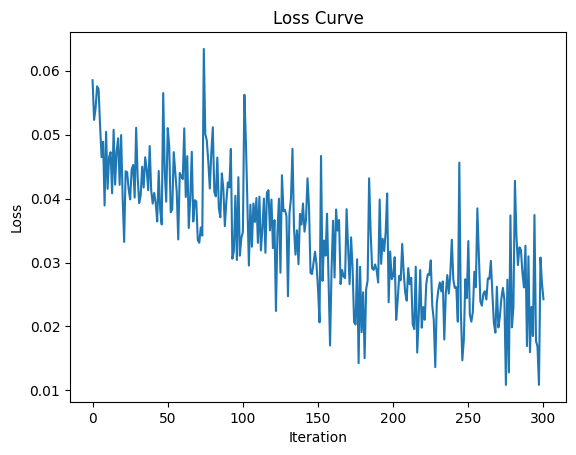

In [12]:
import matplotlib.pyplot as plt
from funlib.geometry import Coordinate

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.savefig("_static/cremi/affs-loss-curve.png")
plt.show()
plt.close()

In [13]:
import mwatershed as mws
from funlib.geometry import Roi
import numpy as np

module = module.eval()
unet = unet.eval()
context = Coordinate(unet.context // 2) * raw_test.voxel_size

In [14]:
raw_input = raw_test.to_ndarray(small_eval_roi.grow(context, context))
raw_output = raw_test.to_ndarray(small_eval_roi)
gt = labels_test.to_ndarray(small_eval_roi)

# Predict on the validation data
with torch.no_grad():
    device = torch.device("cpu")
    module = module.to(device)
    pred = (
        module(
            (torch.from_numpy(raw_input).float() / 255.0)
            .to(device)
            .unsqueeze(0)
            .unsqueeze(0)
        )
        .cpu()
        .detach()
        .numpy()
    )
pred_labels = mws.agglom(pred[0].astype(np.float64) - 0.5, offsets=neighborhood)

In [15]:
# Plot the results
gif_2d(
    arrays={
        "Raw": Array(raw_output, voxel_size=raw_test.voxel_size),
        "GT": Array(gt % 256, voxel_size=raw_test.voxel_size),
        "Pred Affs": Array(pred[0][[0, 3, 4]], voxel_size=raw_test.voxel_size),
        "Pred": Array(pred_labels % 256, voxel_size=raw_test.voxel_size),
    },
    array_types={
        "Raw": "raw",
        "GT": "labels",
        "Pred Affs": "affs",
        "Pred": "labels",
    },
    filename="_static/cremi/affs-prediction.gif",
    title="Prediction",
    fps=10,
)
cube(
    arrays={
        "Raw": Array(raw_output, voxel_size=raw_test.voxel_size),
        "GT": Array(gt, voxel_size=raw_test.voxel_size),
        "Pred Affs": Array(pred[0][[0, 3, 4]], voxel_size=raw_test.voxel_size),
        "Pred": Array(pred_labels, voxel_size=raw_test.voxel_size),
    },
    array_types={
        "Raw": "raw",
        "GT": "labels",
        "Pred Affs": "affs",
        "Pred": "labels",
    },
    filename="_static/cremi/affs-prediction.jpg",
    title="Prediction",
)

Here we visualize the prediction results:
![affs-prediction](_static/cremi/affs-prediction.gif)
![affs-prediction-cube](_static/cremi/affs-prediction.jpg)

## Blockwise Processing
Now that we have a trained model, we can use it to process the full volume.
We will use the `volara` library to do this. It provides a simple interface
for blockwise processing of large volumes. We will use the `volara_torch`
module to wrap our trained model and use it in a blockwise pipeline.

In [16]:
from dacapo_toolbox.postprocessing import blockwise_predict_mutex
from volara.workers import LocalWorker


unet = unet.eval()
scripted_unet = torch.jit.script(module)
torch.jit.save(scripted_unet, "cremi.zarr/affs_unet.pt")
torch.save(scripted_unet.state_dict(), "cremi.zarr/weights.pth")

blocksize = Coordinate(unet.min_output_shape) + blocksize

# default biases:
# interpolate log offset distances to a range of [-0.2, -0.8]

blockwise_predict_mutex(
    raw_store="cremi.zarr/test/raw",
    affs_store="cremi.zarr/test/affs",  # optional, provided for visualization
    frags_store="cremi.zarr/test/frags",  # optional, provided for visualization
    labels_store="cremi.zarr/test/pred_labels",
    neighborhood=neighborhood,
    blocksize=blocksize,
    model_path="cremi.zarr/affs_unet.pt",
    in_channels=1,
    model_context=unet.context // 2,
    predict_worker=LocalWorker(),  # optional, see docstring
    extract_frag_bias=[
        -0.5,
        -0.2,
        -0.2,
        -0.5,
        -0.5,
        -0.8,
        -0.8,
    ],  # optional, TODO: defaults not very good yet
    edge_scores=[  # optional, TODO: defaults not very good yet
        ("affs_z", [Coordinate(1, 0, 0)], -0.5),
        ("affs_xy", [Coordinate(0, 1, 0), Coordinate(0, 0, 1)], -0.2),
        (
            "affs_long_xy",
            [
                Coordinate(0, 7, 0),
                Coordinate(0, 0, 7),
                Coordinate(0, 23, 0),
                Coordinate(0, 0, 23),
            ],
            -0.8,
        ),
    ],
    num_extract_frag_workers=3,
    num_aff_agglom_workers=3,
    num_relabel_workers=3,
    roi=large_eval_roi,
)

INFO:root:Running block with config volara_logs/affs-predict-meta/config.json...


INFO:funlib.persistence.graphs.sqlite_graph_database:dropping collections nodes, edges


/tmp/tmp1bbesi40/lut.npz


affs-predict ▶:   0%|          | 0/9 [00:00<?, ?blocks/s]

affs-predict ▶:   0%|          | 0/9 [00:00<?, ?blocks/s, ⧗=0, ▶=1, ✔=0, ✗=0, ∅=0]

affs-predict ▶:   0%|          | 0/9 [02:08<?, ?blocks/s, ⧗=0, ▶=0, ✔=1, ✗=0, ∅=0]

affs-predict ▶:  11%|█         | 1/9 [02:08<17:09, 128.72s/blocks, ⧗=0, ▶=0, ✔=1, ✗=0, ∅=0]

affs-predict ▶:  11%|█         | 1/9 [02:08<17:09, 128.72s/blocks, ⧗=0, ▶=1, ✔=1, ✗=0, ∅=0]

affs-predict ▶:  11%|█         | 1/9 [04:17<17:09, 128.72s/blocks, ⧗=0, ▶=0, ✔=2, ✗=0, ∅=0]

affs-predict ▶:  22%|██▏       | 2/9 [04:17<14:59, 128.52s/blocks, ⧗=0, ▶=0, ✔=2, ✗=0, ∅=0]

affs-predict ▶:  22%|██▏       | 2/9 [04:17<14:59, 128.52s/blocks, ⧗=0, ▶=1, ✔=2, ✗=0, ∅=0]

affs-predict ▶:  22%|██▏       | 2/9 [06:25<14:59, 128.52s/blocks, ⧗=0, ▶=0, ✔=3, ✗=0, ∅=0]

affs-predict ▶:  33%|███▎      | 3/9 [06:25<12:50, 128.46s/blocks, ⧗=0, ▶=0, ✔=3, ✗=0, ∅=0]

affs-predict ▶:  33%|███▎      | 3/9 [06:25<12:50, 128.46s/blocks, ⧗=0, ▶=1, ✔=3, ✗=0, ∅=0]

affs-predict ▶:  33%|███▎      | 3/9 [08:34<12:50, 128.46s/blocks, ⧗=0, ▶=0, ✔=4, ✗=0, ∅=0]

affs-predict ▶:  44%|████▍     | 4/9 [08:34<10:42, 128.50s/blocks, ⧗=0, ▶=0, ✔=4, ✗=0, ∅=0]

affs-predict ▶:  44%|████▍     | 4/9 [08:34<10:42, 128.50s/blocks, ⧗=0, ▶=1, ✔=4, ✗=0, ∅=0]

affs-predict ▶:  44%|████▍     | 4/9 [10:42<10:42, 128.50s/blocks, ⧗=0, ▶=0, ✔=5, ✗=0, ∅=0]

affs-predict ▶:  56%|█████▌    | 5/9 [10:42<08:34, 128.61s/blocks, ⧗=0, ▶=0, ✔=5, ✗=0, ∅=0]

affs-predict ▶:  56%|█████▌    | 5/9 [10:42<08:34, 128.61s/blocks, ⧗=0, ▶=1, ✔=5, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:getting block


frags-extract-frags ▶:   0%|          | 0/9 [00:00<?, ?blocks/s]

INFO:volara.blockwise.blockwise:got block frags-extract-frags/0 with read ROI [1760:3200, 652:2076, 652:2076] (1440, 1424, 1424) and write ROI [1840:3120, 836:1892, 836:1892] (1280, 1056, 1056)


frags-extract-frags ▶:   0%|          | 0/9 [00:00<?, ?blocks/s, ⧗=8, ▶=1, ✔=0, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:getting block


INFO:volara.blockwise.blockwise:getting block


INFO:/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/volara/blockwise/extract_frags.py:Found 437 fragments


INFO:volara.blockwise.blockwise:getting block


frags-extract-frags ▶:   0%|          | 0/9 [00:10<?, ?blocks/s, ⧗=8, ▶=0, ✔=1, ✗=0, ∅=0]

frags-extract-frags ▶:  11%|█         | 1/9 [00:10<01:22, 10.31s/blocks, ⧗=8, ▶=0, ✔=1, ✗=0, ∅=0]

affs-predict ▶:  56%|█████▌    | 5/9 [12:52<08:34, 128.61s/blocks, ⧗=0, ▶=0, ✔=6, ✗=0, ∅=0]

affs-predict ▶:  67%|██████▋   | 6/9 [12:52<06:27, 129.10s/blocks, ⧗=0, ▶=0, ✔=6, ✗=0, ∅=0]

affs-predict ▶:  67%|██████▋   | 6/9 [12:52<06:27, 129.10s/blocks, ⧗=0, ▶=1, ✔=6, ✗=0, ∅=0]

frags-extract-frags ▶:  11%|█         | 1/9 [02:10<01:22, 10.31s/blocks, ⧗=6, ▶=1, ✔=1, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block frags-extract-frags/1 with read ROI [1760:3200, 652:2076, 1708:3132] (1440, 1424, 1424) and write ROI [1840:3120, 836:1892, 1892:2948] (1280, 1056, 1056)


frags-extract-frags ▶:  11%|█         | 1/9 [02:10<01:22, 10.31s/blocks, ⧗=6, ▶=2, ✔=1, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block frags-extract-frags/4 with read ROI [1760:3200, 652:2076, 2764:4092] (1440, 1424, 1328) and write ROI [1840:3120, 836:1892, 2948:3908] (1280, 1056, 960)


INFO:/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/volara/blockwise/extract_frags.py:Found 460 fragments


INFO:/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/volara/blockwise/extract_frags.py:Found 424 fragments


INFO:volara.blockwise.blockwise:getting block


frags-extract-frags ▶:  11%|█         | 1/9 [02:23<01:22, 10.31s/blocks, ⧗=6, ▶=1, ✔=2, ✗=0, ∅=0]

frags-extract-frags ▶:  22%|██▏       | 2/9 [02:23<09:37, 82.43s/blocks, ⧗=6, ▶=1, ✔=2, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:getting block


frags-extract-frags ▶:  22%|██▏       | 2/9 [02:24<09:37, 82.43s/blocks, ⧗=6, ▶=0, ✔=3, ✗=0, ∅=0]

frags-extract-frags ▶:  33%|███▎      | 3/9 [02:24<04:30, 45.16s/blocks, ⧗=6, ▶=0, ✔=3, ✗=0, ∅=0]

affs-predict ▶:  67%|██████▋   | 6/9 [15:06<06:27, 129.10s/blocks, ⧗=0, ▶=0, ✔=7, ✗=0, ∅=0]

affs-predict ▶:  78%|███████▊  | 7/9 [15:06<04:21, 130.65s/blocks, ⧗=0, ▶=0, ✔=7, ✗=0, ∅=0]

affs-predict ▶:  78%|███████▊  | 7/9 [15:06<04:21, 130.65s/blocks, ⧗=0, ▶=1, ✔=7, ✗=0, ∅=0]

affs-predict ▶:  78%|███████▊  | 7/9 [17:15<04:21, 130.65s/blocks, ⧗=0, ▶=0, ✔=8, ✗=0, ∅=0]

affs-predict ▶:  89%|████████▉ | 8/9 [17:15<02:10, 130.05s/blocks, ⧗=0, ▶=0, ✔=8, ✗=0, ∅=0]

affs-predict ▶:  89%|████████▉ | 8/9 [17:15<02:10, 130.05s/blocks, ⧗=0, ▶=1, ✔=8, ✗=0, ∅=0]

frags-extract-frags ▶:  33%|███▎      | 3/9 [06:32<04:30, 45.16s/blocks, ⧗=4, ▶=1, ✔=3, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block frags-extract-frags/2 with read ROI [1760:3200, 1708:3132, 652:2076] (1440, 1424, 1424) and write ROI [1840:3120, 1892:2948, 836:1892] (1280, 1056, 1056)


frags-extract-frags ▶:  33%|███▎      | 3/9 [06:32<04:30, 45.16s/blocks, ⧗=4, ▶=2, ✔=3, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block frags-extract-frags/7 with read ROI [1760:3200, 2764:4092, 652:2076] (1440, 1328, 1424) and write ROI [1840:3120, 2948:3908, 836:1892] (1280, 960, 1056)


INFO:/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/volara/blockwise/extract_frags.py:Found 683 fragments


INFO:volara.blockwise.blockwise:getting block


frags-extract-frags ▶:  33%|███▎      | 3/9 [06:44<04:30, 45.16s/blocks, ⧗=4, ▶=1, ✔=4, ✗=0, ∅=0]

frags-extract-frags ▶:  44%|████▍     | 4/9 [06:44<10:50, 130.17s/blocks, ⧗=4, ▶=1, ✔=4, ✗=0, ∅=0]

INFO:/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/volara/blockwise/extract_frags.py:Found 447 fragments


INFO:volara.blockwise.blockwise:getting block


frags-extract-frags ▶:  44%|████▍     | 4/9 [06:45<10:50, 130.17s/blocks, ⧗=4, ▶=0, ✔=5, ✗=0, ∅=0]

frags-extract-frags ▶:  56%|█████▌    | 5/9 [06:45<05:34, 83.66s/blocks, ⧗=4, ▶=0, ✔=5, ✗=0, ∅=0] 

affs-predict ▶:  89%|████████▉ | 8/9 [19:25<02:10, 130.05s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

affs-predict ▶: 100%|██████████| 9/9 [19:25<00:00, 130.13s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

affs-predict ✔: 100%|██████████| 9/9 [19:25<00:00, 130.13s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

affs-predict ✔: 100%|██████████| 9/9 [19:25<00:00, 129.53s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

frags-extract-frags ▶:  56%|█████▌    | 5/9 [08:42<05:34, 83.66s/blocks, ⧗=0, ▶=1, ✔=5, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block frags-extract-frags/5 with read ROI [1760:3200, 1708:3132, 1708:3132] (1440, 1424, 1424) and write ROI [1840:3120, 1892:2948, 1892:2948] (1280, 1056, 1056)


frags-extract-frags ▶:  56%|█████▌    | 5/9 [08:43<05:34, 83.66s/blocks, ⧗=0, ▶=2, ✔=5, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block frags-extract-frags/11 with read ROI [1760:3200, 1708:3132, 2764:4092] (1440, 1424, 1328) and write ROI [1840:3120, 1892:2948, 2948:3908] (1280, 1056, 960)


frags-extract-frags ▶:  56%|█████▌    | 5/9 [08:43<05:34, 83.66s/blocks, ⧗=0, ▶=3, ✔=5, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block frags-extract-frags/13 with read ROI [1760:3200, 2764:4092, 1708:3132] (1440, 1328, 1424) and write ROI [1840:3120, 2948:3908, 1892:2948] (1280, 960, 1056)


INFO:/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/volara/blockwise/extract_frags.py:Found 492 fragments


INFO:/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/volara/blockwise/extract_frags.py:Found 702 fragments


INFO:volara.blockwise.blockwise:getting block


frags-extract-frags ▶:  56%|█████▌    | 5/9 [08:53<05:34, 83.66s/blocks, ⧗=0, ▶=2, ✔=6, ✗=0, ∅=0]

frags-extract-frags ▶:  67%|██████▋   | 6/9 [08:53<04:55, 98.55s/blocks, ⧗=0, ▶=2, ✔=6, ✗=0, ∅=0]

frags-extract-frags ▶:  67%|██████▋   | 6/9 [08:53<04:55, 98.55s/blocks, ⧗=0, ▶=3, ✔=6, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block frags-extract-frags/23 with read ROI [1760:3200, 2764:4092, 2764:4092] (1440, 1328, 1328) and write ROI [1840:3120, 2948:3908, 2948:3908] (1280, 960, 960)


INFO:volara.blockwise.blockwise:getting block


fragments-aff-agglom ▶:   0%|          | 0/9 [00:00<?, ?blocks/s]

fragments-aff-agglom ▶:   0%|          | 0/9 [00:00<?, ?blocks/s, ⧗=8, ▶=1, ✔=0, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block fragments-aff-agglom/0 with read ROI [1800:3160, 744:1984, 744:1984] (1360, 1240, 1240) and write ROI [1840:3120, 836:1892, 836:1892] (1280, 1056, 1056)


INFO:volara.blockwise.blockwise:getting block


INFO:volara.blockwise.blockwise:getting block


INFO:volara.blockwise.blockwise:getting block


frags-extract-frags ▶:  67%|██████▋   | 6/9 [08:53<04:55, 98.55s/blocks, ⧗=0, ▶=2, ✔=7, ✗=0, ∅=0]

frags-extract-frags ▶:  78%|███████▊  | 7/9 [08:53<02:12, 66.44s/blocks, ⧗=0, ▶=2, ✔=7, ✗=0, ∅=0]

fragments-aff-agglom ▶:   0%|          | 0/9 [00:00<?, ?blocks/s, ⧗=6, ▶=2, ✔=0, ✗=0, ∅=0]

fragments-aff-agglom ▶:   0%|          | 0/9 [00:00<?, ?blocks/s, ⧗=6, ▶=2, ✔=0, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block None


INFO:volara.blockwise.blockwise:got block fragments-aff-agglom/2 with read ROI [1800:3160, 1800:3040, 744:1984] (1360, 1240, 1240) and write ROI [1840:3120, 1892:2948, 836:1892] (1280, 1056, 1056)


fragments-aff-agglom ▶:   0%|          | 0/9 [00:00<?, ?blocks/s, ⧗=6, ▶=3, ✔=0, ✗=0, ∅=0]

fragments-aff-agglom ▶:   0%|          | 0/9 [00:00<?, ?blocks/s, ⧗=6, ▶=3, ✔=0, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block fragments-aff-agglom/7 with read ROI [1800:3160, 2856:4000, 744:1984] (1360, 1144, 1240) and write ROI [1840:3120, 2948:3908, 836:1892] (1280, 960, 1056)


INFO:/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/volara/blockwise/extract_frags.py:Found 613 fragments


INFO:volara.blockwise.blockwise:getting block


frags-extract-frags ▶:  78%|███████▊  | 7/9 [08:55<02:12, 66.44s/blocks, ⧗=0, ▶=1, ✔=8, ✗=0, ∅=0]

frags-extract-frags ▶:  89%|████████▉ | 8/9 [08:55<00:45, 45.86s/blocks, ⧗=0, ▶=1, ✔=8, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block None


INFO:volara.blockwise.blockwise:getting block


fragments-aff-agglom ▶:   0%|          | 0/9 [00:07<?, ?blocks/s, ⧗=4, ▶=2, ✔=1, ✗=0, ∅=0]

fragments-aff-agglom ▶:  11%|█         | 1/9 [00:07<01:00,  7.52s/blocks, ⧗=4, ▶=2, ✔=1, ✗=0, ∅=0]

fragments-aff-agglom ▶:  11%|█         | 1/9 [00:07<01:00,  7.52s/blocks, ⧗=4, ▶=3, ✔=1, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block fragments-aff-agglom/1 with read ROI [1800:3160, 744:1984, 1800:3040] (1360, 1240, 1240) and write ROI [1840:3120, 836:1892, 1892:2948] (1280, 1056, 1056)


INFO:volara.blockwise.blockwise:getting block


fragments-aff-agglom ▶:  11%|█         | 1/9 [00:09<01:00,  7.52s/blocks, ⧗=4, ▶=2, ✔=2, ✗=0, ∅=0]

fragments-aff-agglom ▶:  22%|██▏       | 2/9 [00:09<00:26,  3.86s/blocks, ⧗=4, ▶=2, ✔=2, ✗=0, ∅=0]

fragments-aff-agglom ▶:  22%|██▏       | 2/9 [00:09<00:26,  3.86s/blocks, ⧗=4, ▶=3, ✔=2, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block fragments-aff-agglom/4 with read ROI [1800:3160, 744:1984, 2856:4000] (1360, 1240, 1144) and write ROI [1840:3120, 836:1892, 2948:3908] (1280, 1056, 960)


INFO:volara.blockwise.blockwise:getting block


fragments-aff-agglom ▶:  22%|██▏       | 2/9 [00:09<00:26,  3.86s/blocks, ⧗=4, ▶=2, ✔=3, ✗=0, ∅=0]

INFO:/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/volara/blockwise/extract_frags.py:Found 761 fragments


INFO:volara.blockwise.blockwise:getting block


frags-extract-frags ▶:  89%|████████▉ | 8/9 [09:06<00:45, 45.86s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

frags-extract-frags ▶: 100%|██████████| 9/9 [09:06<00:00, 34.90s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

frags-extract-frags ✔: 100%|██████████| 9/9 [09:06<00:00, 34.90s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

frags-extract-frags ✔: 100%|██████████| 9/9 [09:06<00:00, 60.68s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block None



fragments-aff-agglom ▶:  33%|███▎      | 3/9 [00:12<00:23,  3.86s/blocks, ⧗=0, ▶=3, ✔=3, ✗=0, ∅=0]

fragments-aff-agglom ▶:  33%|███▎      | 3/9 [00:12<00:22,  3.78s/blocks, ⧗=0, ▶=3, ✔=3, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block fragments-aff-agglom/5 with read ROI [1800:3160, 1800:3040, 1800:3040] (1360, 1240, 1240) and write ROI [1840:3120, 1892:2948, 1892:2948] (1280, 1056, 1056)


INFO:volara.blockwise.blockwise:getting block


fragments-aff-agglom ▶:  33%|███▎      | 3/9 [00:14<00:22,  3.78s/blocks, ⧗=0, ▶=2, ✔=4, ✗=0, ∅=0]

fragments-aff-agglom ▶:  44%|████▍     | 4/9 [00:14<00:15,  3.08s/blocks, ⧗=0, ▶=2, ✔=4, ✗=0, ∅=0]

fragments-aff-agglom ▶:  44%|████▍     | 4/9 [00:14<00:15,  3.08s/blocks, ⧗=0, ▶=3, ✔=4, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block fragments-aff-agglom/11 with read ROI [1800:3160, 1800:3040, 2856:4000] (1360, 1240, 1144) and write ROI [1840:3120, 1892:2948, 2948:3908] (1280, 1056, 960)


INFO:volara.blockwise.blockwise:getting block


fragments-aff-agglom ▶:  44%|████▍     | 4/9 [00:15<00:15,  3.08s/blocks, ⧗=0, ▶=2, ✔=5, ✗=0, ∅=0]

fragments-aff-agglom ▶:  56%|█████▌    | 5/9 [00:15<00:08,  2.24s/blocks, ⧗=0, ▶=2, ✔=5, ✗=0, ∅=0]

fragments-aff-agglom ▶:  56%|█████▌    | 5/9 [00:15<00:08,  2.24s/blocks, ⧗=0, ▶=3, ✔=5, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block fragments-aff-agglom/13 with read ROI [1800:3160, 2856:4000, 1800:3040] (1360, 1144, 1240) and write ROI [1840:3120, 2948:3908, 1892:2948] (1280, 960, 1056)


INFO:volara.blockwise.blockwise:getting block


fragments-aff-agglom ▶:  56%|█████▌    | 5/9 [00:19<00:08,  2.24s/blocks, ⧗=0, ▶=2, ✔=6, ✗=0, ∅=0]

fragments-aff-agglom ▶:  67%|██████▋   | 6/9 [00:19<00:08,  2.85s/blocks, ⧗=0, ▶=2, ✔=6, ✗=0, ∅=0]

fragments-aff-agglom ▶:  67%|██████▋   | 6/9 [00:19<00:08,  2.85s/blocks, ⧗=0, ▶=3, ✔=6, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block fragments-aff-agglom/23 with read ROI [1800:3160, 2856:4000, 2856:4000] (1360, 1144, 1144) and write ROI [1840:3120, 2948:3908, 2948:3908] (1280, 960, 960)


INFO:volara.blockwise.blockwise:getting block


fragments-aff-agglom ▶:  67%|██████▋   | 6/9 [00:23<00:08,  2.85s/blocks, ⧗=0, ▶=2, ✔=7, ✗=0, ∅=0]

fragments-aff-agglom ▶:  78%|███████▊  | 7/9 [00:23<00:06,  3.07s/blocks, ⧗=0, ▶=2, ✔=7, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block None


INFO:volara.blockwise.blockwise:getting block


fragments-aff-agglom ▶:  78%|███████▊  | 7/9 [00:24<00:06,  3.07s/blocks, ⧗=0, ▶=1, ✔=8, ✗=0, ∅=0]

fragments-aff-agglom ▶:  89%|████████▉ | 8/9 [00:24<00:02,  2.54s/blocks, ⧗=0, ▶=1, ✔=8, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block None


INFO:volara.blockwise.blockwise:getting block


fragments-aff-agglom ▶:  89%|████████▉ | 8/9 [00:25<00:02,  2.54s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

fragments-aff-agglom ▶: 100%|██████████| 9/9 [00:25<00:00,  1.91s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

fragments-aff-agglom ✔: 100%|██████████| 9/9 [00:25<00:00,  1.91s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

fragments-aff-agglom ✔: 100%|██████████| 9/9 [00:25<00:00,  2.79s/blocks, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:getting block


lut-graph-mws ▶:   0%|          | 0/1 [00:00<?, ?blocks/s]

INFO:volara.blockwise.blockwise:got block lut-graph-mws/0 with read ROI [1840:3120, 836:3908, 836:3908] (1280, 3072, 3072) and write ROI [1840:3120, 836:3908, 836:3908] (1280, 3072, 3072)


lut-graph-mws ▶:   0%|          | 0/1 [00:00<?, ?blocks/s, ⧗=0, ▶=1, ✔=0, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block None


INFO:volara.blockwise.blockwise:getting block


lut-graph-mws ▶:   0%|          | 0/1 [00:00<?, ?blocks/s, ⧗=0, ▶=0, ✔=1, ✗=0, ∅=0]

lut-graph-mws ▶: 100%|██████████| 1/1 [00:00<00:00,  2.91blocks/s, ⧗=0, ▶=0, ✔=1, ✗=0, ∅=0]

lut-graph-mws ✔: 100%|██████████| 1/1 [00:00<00:00,  2.91blocks/s, ⧗=0, ▶=0, ✔=1, ✗=0, ∅=0]

lut-graph-mws ✔: 100%|██████████| 1/1 [00:00<00:00,  2.90blocks/s, ⧗=0, ▶=0, ✔=1, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:getting block


pred_labels-relabel ▶:   0%|          | 0/9 [00:00<?, ?blocks/s]

INFO:volara.blockwise.blockwise:got block pred_labels-relabel/0 with read ROI [1840:3120, 836:1892, 836:1892] (1280, 1056, 1056) and write ROI [1840:3120, 836:1892, 836:1892] (1280, 1056, 1056)


pred_labels-relabel ▶:   0%|          | 0/9 [00:00<?, ?blocks/s, ⧗=0, ▶=1, ✔=0, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:getting block


pred_labels-relabel ▶:   0%|          | 0/9 [00:00<?, ?blocks/s, ⧗=0, ▶=2, ✔=0, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block pred_labels-relabel/1 with read ROI [1840:3120, 836:1892, 1892:2948] (1280, 1056, 1056) and write ROI [1840:3120, 836:1892, 1892:2948] (1280, 1056, 1056)


INFO:volara.blockwise.blockwise:got block None


INFO:volara.blockwise.blockwise:getting block


pred_labels-relabel ▶:   0%|          | 0/9 [00:00<?, ?blocks/s, ⧗=0, ▶=3, ✔=0, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block pred_labels-relabel/2 with read ROI [1840:3120, 1892:2948, 836:1892] (1280, 1056, 1056) and write ROI [1840:3120, 1892:2948, 836:1892] (1280, 1056, 1056)


INFO:volara.blockwise.blockwise:getting block


pred_labels-relabel ▶:   0%|          | 0/9 [00:02<?, ?blocks/s, ⧗=0, ▶=2, ✔=1, ✗=0, ∅=0]

pred_labels-relabel ▶:  11%|█         | 1/9 [00:02<00:16,  2.11s/blocks, ⧗=0, ▶=2, ✔=1, ✗=0, ∅=0]

pred_labels-relabel ▶:  11%|█         | 1/9 [00:02<00:16,  2.11s/blocks, ⧗=0, ▶=3, ✔=1, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block pred_labels-relabel/4 with read ROI [1840:3120, 836:1892, 2948:3908] (1280, 1056, 960) and write ROI [1840:3120, 836:1892, 2948:3908] (1280, 1056, 960)


INFO:volara.blockwise.blockwise:getting block


pred_labels-relabel ▶:  11%|█         | 1/9 [00:02<00:16,  2.11s/blocks, ⧗=0, ▶=2, ✔=2, ✗=0, ∅=0]

pred_labels-relabel ▶:  22%|██▏       | 2/9 [00:02<00:06,  1.06blocks/s, ⧗=0, ▶=2, ✔=2, ✗=0, ∅=0]

pred_labels-relabel ▶:  22%|██▏       | 2/9 [00:02<00:06,  1.06blocks/s, ⧗=0, ▶=3, ✔=2, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block pred_labels-relabel/5 with read ROI [1840:3120, 1892:2948, 1892:2948] (1280, 1056, 1056) and write ROI [1840:3120, 1892:2948, 1892:2948] (1280, 1056, 1056)


INFO:volara.blockwise.blockwise:getting block


pred_labels-relabel ▶:  22%|██▏       | 2/9 [00:02<00:06,  1.06blocks/s, ⧗=0, ▶=2, ✔=3, ✗=0, ∅=0]

pred_labels-relabel ▶:  33%|███▎      | 3/9 [00:02<00:03,  1.73blocks/s, ⧗=0, ▶=2, ✔=3, ✗=0, ∅=0]

pred_labels-relabel ▶:  33%|███▎      | 3/9 [00:02<00:03,  1.73blocks/s, ⧗=0, ▶=3, ✔=3, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block pred_labels-relabel/7 with read ROI [1840:3120, 2948:3908, 836:1892] (1280, 960, 1056) and write ROI [1840:3120, 2948:3908, 836:1892] (1280, 960, 1056)


INFO:volara.blockwise.blockwise:getting block


pred_labels-relabel ▶:  33%|███▎      | 3/9 [00:02<00:03,  1.73blocks/s, ⧗=0, ▶=2, ✔=4, ✗=0, ∅=0]

pred_labels-relabel ▶:  44%|████▍     | 4/9 [00:02<00:02,  2.48blocks/s, ⧗=0, ▶=2, ✔=4, ✗=0, ∅=0]

pred_labels-relabel ▶:  44%|████▍     | 4/9 [00:02<00:02,  2.48blocks/s, ⧗=0, ▶=3, ✔=4, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block pred_labels-relabel/11 with read ROI [1840:3120, 1892:2948, 2948:3908] (1280, 1056, 960) and write ROI [1840:3120, 1892:2948, 2948:3908] (1280, 1056, 960)


INFO:volara.blockwise.blockwise:getting block


INFO:volara.blockwise.blockwise:getting block


pred_labels-relabel ▶:  44%|████▍     | 4/9 [00:02<00:02,  2.48blocks/s, ⧗=0, ▶=2, ✔=5, ✗=0, ∅=0]

pred_labels-relabel ▶:  56%|█████▌    | 5/9 [00:02<00:01,  2.48blocks/s, ⧗=0, ▶=1, ✔=6, ✗=0, ∅=0]

pred_labels-relabel ▶:  67%|██████▋   | 6/9 [00:02<00:01,  2.48blocks/s, ⧗=0, ▶=2, ✔=6, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block pred_labels-relabel/13 with read ROI [1840:3120, 2948:3908, 1892:2948] (1280, 960, 1056) and write ROI [1840:3120, 2948:3908, 1892:2948] (1280, 960, 1056)


pred_labels-relabel ▶:  67%|██████▋   | 6/9 [00:02<00:01,  2.48blocks/s, ⧗=0, ▶=3, ✔=6, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:got block pred_labels-relabel/23 with read ROI [1840:3120, 2948:3908, 2948:3908] (1280, 960, 960) and write ROI [1840:3120, 2948:3908, 2948:3908] (1280, 960, 960)


pred_labels-relabel ▶:  67%|██████▋   | 6/9 [00:02<00:00,  4.63blocks/s, ⧗=0, ▶=3, ✔=6, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:getting block


pred_labels-relabel ▶:  67%|██████▋   | 6/9 [00:02<00:00,  4.63blocks/s, ⧗=0, ▶=2, ✔=7, ✗=0, ∅=0]

INFO:volara.blockwise.blockwise:getting block


INFO:volara.blockwise.blockwise:getting block


pred_labels-relabel ▶:  78%|███████▊  | 7/9 [00:02<00:00,  4.63blocks/s, ⧗=0, ▶=1, ✔=8, ✗=0, ∅=0]

pred_labels-relabel ▶:  89%|████████▉ | 8/9 [00:02<00:00,  4.63blocks/s, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

pred_labels-relabel ✔: 100%|██████████| 9/9 [00:02<00:00,  4.63blocks/s, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]

pred_labels-relabel ✔: 100%|██████████| 9/9 [00:02<00:00,  3.33blocks/s, ⧗=0, ▶=0, ✔=9, ✗=0, ∅=0]


Execution Summary
-----------------

  Task affs-predict:

    num blocks : 9
    completed ✔: 9 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully

  Task frags-extract-frags:

    num blocks : 9
    completed ✔: 9 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully

  Task fragments-aff-agglom:

    num blocks : 9
    completed ✔: 9 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully

  Task lut-graph-mws:

    num blocks : 1
    completed ✔: 1 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully

  Task pred_labels-relabel:

    num blocks : 9
    completed ✔: 9 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


## Visualizing the results

In [17]:
from funlib.persistence import open_ds

affs = open_ds("cremi.zarr/test/affs")
affs.lazy_op(lambda x: x[[0, 3, 4]] / 255.0)
raw = open_ds("cremi.zarr/test/raw")
raw.lazy_op(large_eval_roi)
gif_2d(
    arrays={
        "Raw": raw,
        "Affs": affs,
        "Frags": open_ds("cremi.zarr/test/frags"),
        "Pred Labels": open_ds("cremi.zarr/test/pred_labels"),
    },
    array_types={
        "Raw": "raw",
        "Affs": "affs",
        "Frags": "labels",
        "Pred Labels": "labels",
    },
    title="CREMI Affs Prediction",
    filename="_static/cremi/cremi-prediction.gif",
    fps=10,
)
cube(
    arrays={
        "raw": raw,
        "affs": affs,
        "frags": open_ds("cremi.zarr/test/frags"),
        "pred_labels": open_ds("cremi.zarr/test/pred_labels"),
    },
    array_types={
        "raw": "raw",
        "affs": "affs",
        "frags": "labels",
        "pred_labels": "labels",
    },
    title="CREMI Affs Prediction",
    filename="_static/cremi/cremi-prediction.jpg",
)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Here we visualize the prediction results:
![cremi-prediction](_static/cremi/cremi-prediction.gif)
![cremi-prediction-cube](_static/cremi/cremi-prediction.jpg)